In [ ]:
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, RNN
from keras.regularizers import l2
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt

2024-07-25 12:48:56.699768: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data analysis and preparation

In [2]:
max_features = 10000  # кількість слів, що розглядаються як особливості
maxlen = 500  # обмеження кількості слів в тексті
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)



### Data output


This code outputs the first review from the training set, decoded from indices back into words. Note that the indices are offset by 3 because 0, 1, and 2 are reserved for special tokens (such as padding, the start of the sequence, etc.).

Этот код выводит первую рецензию из тренировочного набора, декодированную из индексов обратно в слова. Обратите внимание, что индексы смещены на 3, потому что 0, 1 и 2 зарезервированы для специальных токенов (например, заполнителя, начала последовательности и т.д.).

In [3]:
# Получение словаря индексов и слов
word_index = imdb.get_word_index() 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in input_train[10]])
print(decoded_review)

? french horror cinema has seen something of a revival over the last couple of years with great films such as inside and ? romance ? on to the scene ? ? the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made ? was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is ? by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named ? sent to prison for fraud he is put in a cell with three others the quietly insane ? body building ? marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old ? after ? part of it they soon realise its magical powers and realise they may be able to use it to break through the prison walls br br black magi

### Padding

In [4]:

input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)

# Building and Comparing Recurrent Models

In [59]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_names = []
test_accuracies = [] 
test_losses = []

# Установим коллбэки для остановки обучения при отсутствии улучшений и уменьшения скорости обучения
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

def plot_acc_loss_history(history, title=""):
    plt.figure(figsize=(13,3))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")  
    plt.fill_between(range(len(history.history['accuracy'])), history.history['accuracy'], history.history['val_accuracy'], alpha=0.2)
    plt.grid()
    plt.xticks(range(1, len(history.history['accuracy'])+1))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], alpha=0.2)
    plt.grid()
    plt.xticks(range(1, len(history.history['loss'])+1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    if len(title):
        plt.suptitle(title, fontsize=20)
    plt.show()


def make_predictions(model, name: str):

    predictions = model.predict(input_test)

    # Для отримання зрозумілішого вигляду прогнозів, їх можна перетворити в бінарний формат:
    binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

    # Для порівняння можна вивести деякі прогнозовані значення поряд з фактичними значеннями
    for i in range(10):
        print(f"Predicted: {binary_predictions[i]}, Actual: {y_test[i]}")

    # Додатковий крок: Оцінка моделі
    # Це дасть загальну точність моделі на тестових даних
    test_loss, test_acc = model.evaluate(input_test, y_test)
    print(name,' Test Loss: {}'.format(test_loss))
    print(name, ' Test Accuracy: {}'.format(test_acc))

## Simple RNN

In [7]:
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, 64))  # Увеличенный размер эмбеддинга
model_rnn.add(SimpleRNN(64, return_sequences=True))  # Первый слой SimpleRNN
model_rnn.add(Dropout(0.5))  # Dropout для регуляризации
model_rnn.add(SimpleRNN(64))  # Второй слой SimpleRNN
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 64)          8256      
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 656,577
Trainable params: 656,577
Non-trai

In [8]:
start_time = time.time()
history_rnn = model_rnn.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
rnn_training_time = end_time - start_time

test_loss, test_acc = model_rnn.evaluate(input_test, y_test)
print(f"Simple RNN Model training time: {rnn_training_time:.2f} seconds")
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

Epoch 1/150
782/782 [==============================] - 102s 129ms/step - loss: 0.6714 - accuracy: 0.5934 - val_loss: 0.6786 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 108s 138ms/step - loss: 0.6579 - accuracy: 0.6116 - val_loss: 0.5846 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 111s 142ms/step - loss: 0.6497 - accuracy: 0.6136 - val_loss: 0.6653 - val_accuracy: 0.6235 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 112s 144ms/step - loss: 0.6269 - accuracy: 0.6416 - val_loss: 0.5879 - val_accuracy: 0.7237 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 114s 145ms/step - loss: 0.5206 - accuracy: 0.7545 - val_loss: 0.5085 - val_accuracy: 0.7485 - lr: 0.0010
Epoch 6/150
782/782 [==============================] - 147s 188ms/step - loss: 0.4704 - accuracy: 0.7801 - val_loss: 0.4326 - val_accuracy: 0.8102 - lr: 0.0010
Epoch 7/150
782/782 [===================

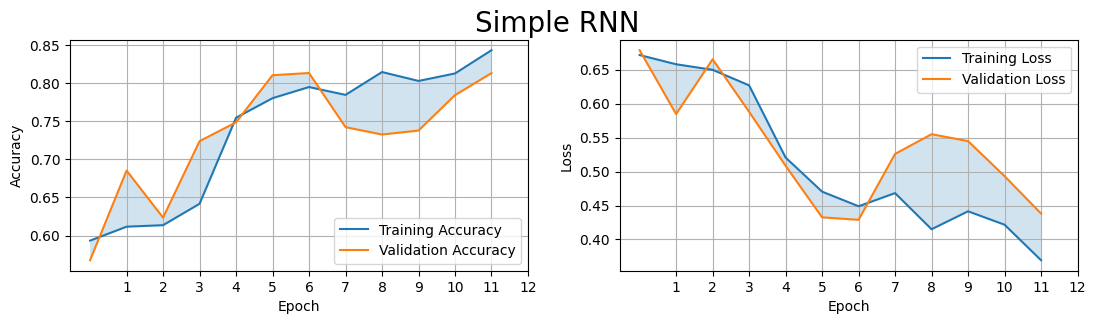

782/782 [==============================] - 21s 27ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 22s 27ms/step - loss: 0.4289 - accuracy: 0.8131
Simple RNN  Test Loss: 0.4289369583129883
Simple RNN  Test Accuracy: 0.8130800127983093


In [29]:
plot_acc_loss_history(history_rnn, "Simple RNN")
make_predictions(model_rnn, "Simple RNN")

In [60]:
model_names.append("model rnn")
test_accuracies.append(test_loss)
test_losses.append(test_acc)

In [10]:
model_rnn_2 = Sequential()
model_rnn_2.add(Embedding(max_features, 32))
model_rnn_2.add(SimpleRNN(32))
model_rnn_2.add(Dropout(0.5))
model_rnn_2.add(Dense(128, activation='relu'))
model_rnn_2.add(Dense(1, activation='sigmoid'))

model_rnn_2.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_rnn_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 326,433
Trainable params: 326,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
start_time = time.time()
history_rnn_2 = model_rnn_2.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
rnn_2_training_time = end_time - start_time

test_loss_rnn_2, test_acc_rnn_2 = model_rnn_2.evaluate(input_test, y_test)
print(f"Simple RNN Model training time: {rnn_2_training_time:.2f} seconds")
print("Test accuracy:", test_acc_rnn_2)
print("Test loss:", test_loss_rnn_2)

Epoch 1/150
782/782 [==============================] - 49s 62ms/step - loss: 0.6043 - accuracy: 0.6436 - val_loss: 0.4834 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 46s 59ms/step - loss: 0.4548 - accuracy: 0.7962 - val_loss: 0.5841 - val_accuracy: 0.6933 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 46s 59ms/step - loss: 0.4560 - accuracy: 0.7907 - val_loss: 1.1770 - val_accuracy: 0.5264 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 47s 60ms/step - loss: 0.6208 - accuracy: 0.6474 - val_loss: 0.6257 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 47s 60ms/step - loss: 0.6057 - accuracy: 0.6586 - val_loss: 0.6149 - val_accuracy: 0.6482 - lr: 2.0000e-04
Epoch 6/150
782/782 [==============================] - 10s 13ms/step - loss: 0.4834 - accuracy: 0.7718
Simple RNN Model training time: 283.62 seconds
Test accuracy: 0.7717599868774414
Test loss: 0.483411341

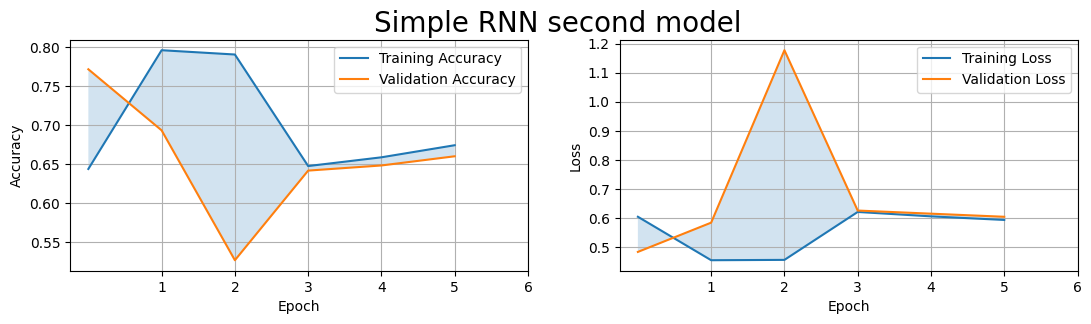

782/782 [==============================] - 11s 14ms/step
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
782/782 [==============================] - 11s 14ms/step - loss: 0.4834 - accuracy: 0.7718
Simple RNN second model  Test Loss: 0.48341134190559387
Simple RNN second model  Test Accuracy: 0.7717599868774414


In [31]:
plot_acc_loss_history(history_rnn_2, "Simple RNN second model")
make_predictions(model_rnn_2, "Simple RNN second model")

In [61]:
model_names.append("Simple RNN second model")
test_accuracies.append(test_loss_rnn_2)
test_losses.append(test_acc_rnn_2)

## GRU

In [13]:
model_gru = Sequential()
model_gru.add(Embedding(max_features, 32))
model_gru.add(GRU(32))
# model_gru.add(GRU(32, kernel_regularizer=l2(0.01)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(128, activation='relu'))
# model_gru.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_gru.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               4224      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 330,689
Trainable params: 330,689
Non-trainable params: 0
_________________________________________________________________


2024-07-25 13:34:38.553398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 13:34:38.556785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 13:34:38.557936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
start_time = time.time()
history_gru = model_gru.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
gru_training_time = end_time - start_time

test_loss_gru, test_acc_gru = model_gru.evaluate(input_test, y_test)
print(f"GRU Model training time: {gru_training_time:.2f} seconds")
print("Test accuracy:", test_acc_gru)
print("Test loss:", test_loss_gru)

Epoch 1/150


2024-07-25 13:35:01.228117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 13:35:01.229333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 13:35:01.230222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.4347 - accuracy: 0.7823

2024-07-25 13:36:22.560843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 13:36:22.561941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 13:36:22.562889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 96s 120ms/step - loss: 0.4347 - accuracy: 0.7823 - val_loss: 0.3860 - val_accuracy: 0.8576 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 92s 118ms/step - loss: 0.2417 - accuracy: 0.9090 - val_loss: 0.2913 - val_accuracy: 0.8814 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 94s 120ms/step - loss: 0.1745 - accuracy: 0.9364 - val_loss: 0.3166 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 95s 121ms/step - loss: 0.1239 - accuracy: 0.9587 - val_loss: 0.3831 - val_accuracy: 0.8784 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 95s 122ms/step - loss: 0.0895 - accuracy: 0.9705 - val_loss: 0.3938 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 6/150
782/782 [==============================] - 96s 122ms/step - loss: 0.0435 - accuracy: 0.9876 - val_loss: 0.5048 - val_accuracy: 0.8719 - lr: 2.0000e-04
Epoch 7/150
782/782 [==============================] -

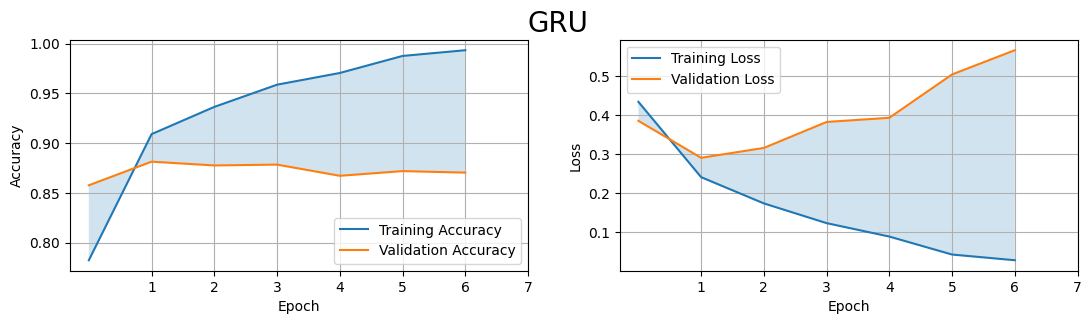

782/782 [==============================] - 15s 19ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 16s 20ms/step - loss: 0.2913 - accuracy: 0.8814
GRU  Test Loss: 0.29127341508865356
GRU  Test Accuracy: 0.8813599944114685


In [62]:
plot_acc_loss_history(history_gru, "GRU")
make_predictions(model_gru, "GRU")


In [64]:
model_names.append("GRU")
test_accuracies.append(test_loss_gru)
test_losses.append(test_acc_gru)

In [16]:
model_gru_2 = Sequential()
model_gru_2.add(Embedding(max_features, 64))  # Увеличенный размер эмбеддинга
model_gru_2.add(GRU(64, return_sequences=True))  # Первый слой SimpleRNN
model_gru_2.add(Dropout(0.5))  # Dropout для регуляризации
model_gru_2.add(GRU(64))  # Второй слой SimpleRNN
model_gru_2.add(Dropout(0.5))
model_gru_2.add(Dense(1, activation='sigmoid'))

model_gru_2.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_gru_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640000    
                                                                 
 gru_1 (GRU)                 (None, None, 64)          24960     
                                                                 
 dropout_4 (Dropout)         (None, None, 64)          0         
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 689,985
Trainable params: 689,985
Non-tr

2024-07-25 14:06:47.828052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 14:06:47.830961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 14:06:47.831898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
start_time = time.time()
history_gru_2 = model_gru_2.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
gru_2_training_time = end_time - start_time

test_loss_gru_2, test_acc_gru_2 = model_gru_2.evaluate(input_test, y_test)
print(f"GRU Model training time: {gru_2_training_time:.2f} seconds")
print("Test accuracy:", test_acc_gru_2)
print("Test loss:", test_loss_gru_2)

Epoch 1/150


2024-07-25 14:07:07.815828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 14:07:07.817165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 14:07:07.818110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.7912

2024-07-25 14:10:19.127371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 14:10:19.128938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 14:10:19.129956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 251s 316ms/step - loss: 0.4408 - accuracy: 0.7912 - val_loss: 0.3777 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 255s 327ms/step - loss: 0.2344 - accuracy: 0.9114 - val_loss: 0.2933 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 1215s 2s/step - loss: 0.1558 - accuracy: 0.9457 - val_loss: 0.3112 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 468s 599ms/step - loss: 0.1011 - accuracy: 0.9670 - val_loss: 0.3658 - val_accuracy: 0.8631 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 250s 320ms/step - loss: 0.0648 - accuracy: 0.9791 - val_loss: 0.4477 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 6/150
782/782 [==============================] - 258s 330ms/step - loss: 0.0262 - accuracy: 0.9928 - val_loss: 0.5339 - val_accuracy: 0.8746 - lr: 2.0000e-04
Epoch 7/150
782/782 [=============================

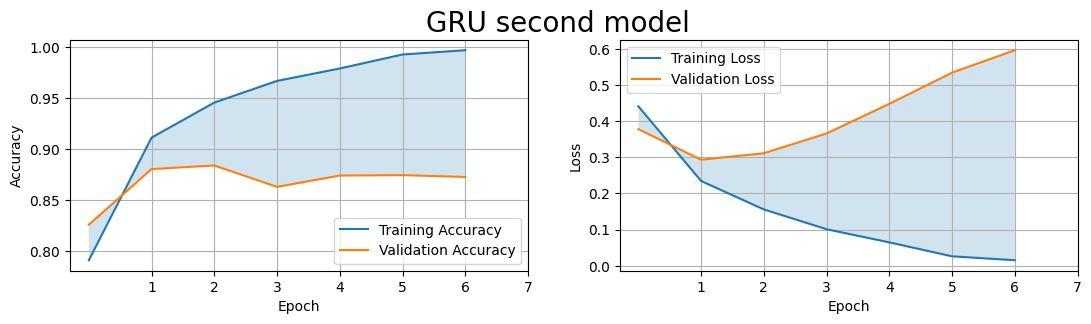

782/782 [==============================] - 70s 89ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 69s 89ms/step - loss: 0.2933 - accuracy: 0.8805
GRU second model  Test Loss: 0.29331284761428833
GRU second model  Test Accuracy: 0.8805199861526489


In [72]:
plot_acc_loss_history(history_gru_2, "GRU second model")
make_predictions(model_gru_2, "GRU second model")

In [66]:
model_names.append("GRU second model")
test_accuracies.append(test_loss_gru_2)
test_losses.append(test_acc_gru_2)

## LSTM

In [34]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, 32))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 332,673
Trainable params: 332,673
Non-trainable params: 0
_________________________________________________________________


2024-07-25 16:25:51.299789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:25:51.302298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:25:51.303273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [35]:
start_time = time.time()
history_lstm = model_lstm.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
lstm_training_time = end_time - start_time

test_loss_lstm, test_acc_lstm = model_lstm.evaluate(input_test, y_test)
print(f"LSTM Model training time: {lstm_training_time:.2f} seconds")
print("Test accuracy:", test_acc_lstm)
print("Test loss:", test_loss_lstm)

Epoch 1/150


2024-07-25 16:27:38.344441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:27:38.346973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:27:38.348787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.8006

2024-07-25 16:28:58.230998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:28:58.232414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:28:58.233394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 97s 122ms/step - loss: 0.4310 - accuracy: 0.8006 - val_loss: 0.3267 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 94s 121ms/step - loss: 0.2603 - accuracy: 0.9036 - val_loss: 0.3079 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 93s 118ms/step - loss: 0.2066 - accuracy: 0.9236 - val_loss: 0.3599 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 93s 119ms/step - loss: 0.1517 - accuracy: 0.9470 - val_loss: 0.4068 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 98s 125ms/step - loss: 0.1222 - accuracy: 0.9568 - val_loss: 0.3922 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 6/150
782/782 [==============================] - 99s 126ms/step - loss: 0.0638 - accuracy: 0.9816 - val_loss: 0.4711 - val_accuracy: 0.8670 - lr: 2.0000e-04
Epoch 7/150
782/782 [==============================] -

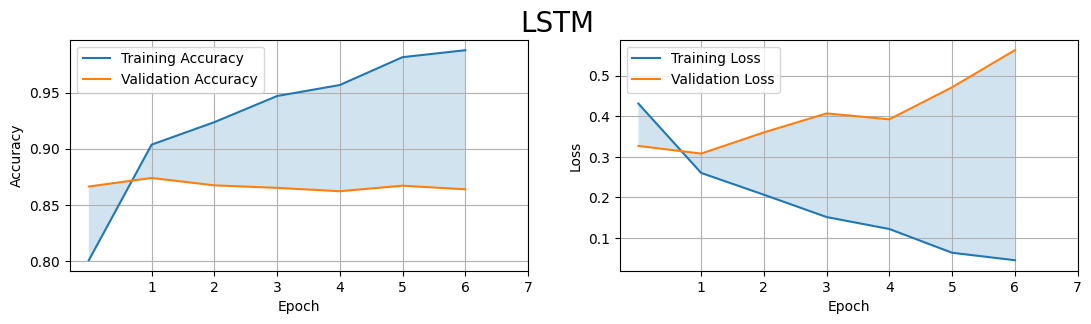

2024-07-25 16:39:53.239032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:39:53.242955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:39:53.243977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 19s 24ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 22s 28ms/step - loss: 0.3079 - accuracy: 0.8739
LSTM  Test Loss: 0.30787011981010437
LSTM  Test Accuracy: 0.8739200234413147


In [36]:
plot_acc_loss_history(history_lstm, "LSTM")
make_predictions(model_lstm, "LSTM")

In [67]:
model_names.append("LSTM")
test_accuracies.append(test_loss_lstm)
test_losses.append(test_acc_lstm)

In [37]:
model_lstm_2 = Sequential()
model_lstm_2.add(Embedding(max_features, 64))  # Увеличенный размер эмбеддинга
model_lstm_2.add(GRU(64, return_sequences=True))  # Первый слой SimpleRNN
model_lstm_2.add(Dropout(0.5))  # Dropout для регуляризации
model_lstm_2.add(GRU(64))  # Второй слой SimpleRNN
model_lstm_2.add(Dropout(0.5))
model_lstm_2.add(Dense(1, activation='sigmoid'))

model_lstm_2.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_lstm_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          640000    
                                                                 
 gru_3 (GRU)                 (None, None, 64)          24960     
                                                                 
 dropout_7 (Dropout)         (None, None, 64)          0         
                                                                 
 gru_4 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 689,985
Trainable params: 689,985
Non-tr

2024-07-25 16:41:24.853348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:41:24.854412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:41:24.855118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [39]:
start_time = time.time()
history_lstm_2 = model_lstm_2.fit(
    input_train,
    y_train,
    epochs=150,  # Значение может быть изменено в зависимости от задачи и доступных ресурсов
    validation_data=(input_test, y_test),
    callbacks=[early_stopping, reduce_lr],
)
end_time = time.time()
lstm_2_training_time = end_time - start_time

test_loss_lstm_2, test_acc_lstm_2 = model_lstm_2.evaluate(input_test, y_test)
print(f"LSTM Model training time: {lstm_2_training_time:.2f} seconds")
print("Test accuracy:", test_acc_lstm_2)
print("Test loss:", test_loss_lstm_2)

Epoch 1/150
782/782 [==============================] - 272s 348ms/step - loss: 0.0843 - accuracy: 0.9733 - val_loss: 0.3815 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 2/150
782/782 [==============================] - 283s 361ms/step - loss: 0.0499 - accuracy: 0.9853 - val_loss: 0.4796 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 3/150
782/782 [==============================] - 298s 381ms/step - loss: 0.0355 - accuracy: 0.9887 - val_loss: 0.5647 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 4/150
782/782 [==============================] - 2854s 4s/step - loss: 0.0283 - accuracy: 0.9910 - val_loss: 0.5886 - val_accuracy: 0.8556 - lr: 0.0010
Epoch 5/150
782/782 [==============================] - 1535s 2s/step - loss: 0.0103 - accuracy: 0.9973 - val_loss: 0.7311 - val_accuracy: 0.8640 - lr: 2.0000e-04
Epoch 6/150
782/782 [==============================] - 63s 80ms/step - loss: 0.3815 - accuracy: 0.8696
GRU Model training time: 7217.86 seconds
Test accuracy: 0.8695999979972839
Test loss: 0.381467610

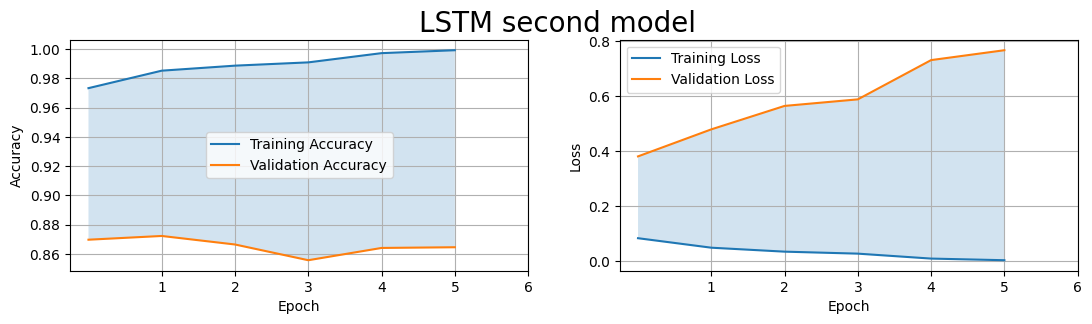

2024-07-25 19:48:40.195664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 19:48:40.199356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 19:48:40.200633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

782/782 [==============================] - 70s 88ms/step
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
782/782 [==============================] - 67s 85ms/step - loss: 0.3815 - accuracy: 0.8696
LSTM second model  Test Loss: 0.3814676105976105
LSTM second model  Test Accuracy: 0.8695999979972839


In [40]:
plot_acc_loss_history(history_lstm_2, "LSTM second model")
make_predictions(model_lstm_2, "LSTM second model")

In [68]:
model_names.append("LSTM second model")
test_accuracies.append(test_loss_lstm_2)
test_losses.append(test_acc_lstm_2)

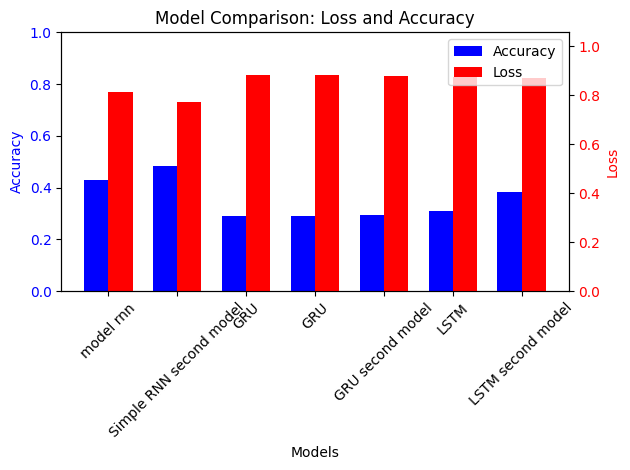

In [71]:
# Параметры для графика
x = np.arange(len(model_names))
width = 0.35  # Ширина баров

# Построение графика
fig, ax1 = plt.subplots()

# Бары для точности
bars1 = ax1.bar(x - width/2, test_accuracies, width, label='Accuracy', color='blue')

# Установка оси y для точности
ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy', color='blue')
ax1.set_title('Model Comparison: Loss and Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='blue')

# Построение второго графика
ax2 = ax1.twinx()  # Создание второго объекта оси, разделяющего ту же ось x
bars2 = ax2.bar(x + width/2, test_losses, width, label='Loss', color='red')

# Установка оси y для потерь
ax2.set_ylabel('Loss', color='red')
ax2.set_ylim(0, max(test_losses) * 1.2)
ax2.tick_params(axis='y', labelcolor='red')

# Легенда
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Отображение графика
plt.tight_layout()
plt.show()